In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [41]:
# Load train/val/test
train_df = pd.read_csv("train_data.csv")
val_df   = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")

# Separate features and labels
X_train = train_df.iloc[:, :-6]  # all columns except last 6
y_train = train_df.iloc[:, -6:]  # last 6 columns

X_val   = val_df.iloc[:, :-6]
y_val   = val_df.iloc[:, -6:]

X_test  = test_df.iloc[:, :-6]
y_test  = test_df.iloc[:, -6:]

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (144, 30) (144, 6)
Validation shape: (31, 30) (31, 6)
Test shape: (32, 30) (32, 6)


In [42]:
# CNN expects 3D input: (samples, timesteps, channels)
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn   = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_cnn  = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Reshaped Train:", X_train_cnn.shape)
print("Reshaped Validation:", X_val_cnn.shape)
print("Reshaped Test:", X_test_cnn.shape)


Reshaped Train: (144, 30, 1)
Reshaped Validation: (31, 30, 1)
Reshaped Test: (32, 30, 1)


In [43]:
n_features = X_train_cnn.shape[1]
n_labels = y_train.shape[1]

model_nadam = Sequential([
    Input(shape=(n_features, 1)),

    # Convolutional Block
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.2),

    # Output layer for multi-label classification
    Dense(n_labels, activation='sigmoid')
])

# Nadam optimizer
optimizer_nadam = Nadam(learning_rate=0.001)

model_nadam.compile(
    optimizer=optimizer_nadam,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_nadam.summary()


Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_131 (Conv1D)         (None, 30, 64)            256       
                                                                 
 batch_normalization_134 (Ba  (None, 30, 64)           256       
 tchNormalization)                                               
                                                                 
 dropout_263 (Dropout)       (None, 30, 64)            0         
                                                                 
 conv1d_132 (Conv1D)         (None, 30, 64)            12352     
                                                                 
 batch_normalization_135 (Ba  (None, 30, 64)           256       
 tchNormalization)                                               
                                                                 
 dropout_264 (Dropout)       (None, 30, 64)         

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [45]:
history_nadam = model_nadam.fit(
    X_train_cnn, y_train.values,
    validation_data=(X_val_cnn, y_val.values),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
5/5 [==============================] - 3s 59ms/step - loss: 0.9337 - accuracy: 0.0903 - val_loss: 0.6920 - val_accuracy: 0.1613 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 0.8063 - accuracy: 0.1667 - val_loss: 0.6792 - val_accuracy: 0.1935 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6617 - accuracy: 0.2569 - val_loss: 0.6651 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5773 - accuracy: 0.3750 - val_loss: 0.6499 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 0.5356 - accuracy: 0.4097 - val_loss: 0.6341 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4767 - accuracy: 0.3472 - val_loss: 0.6190 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4227 - accuracy

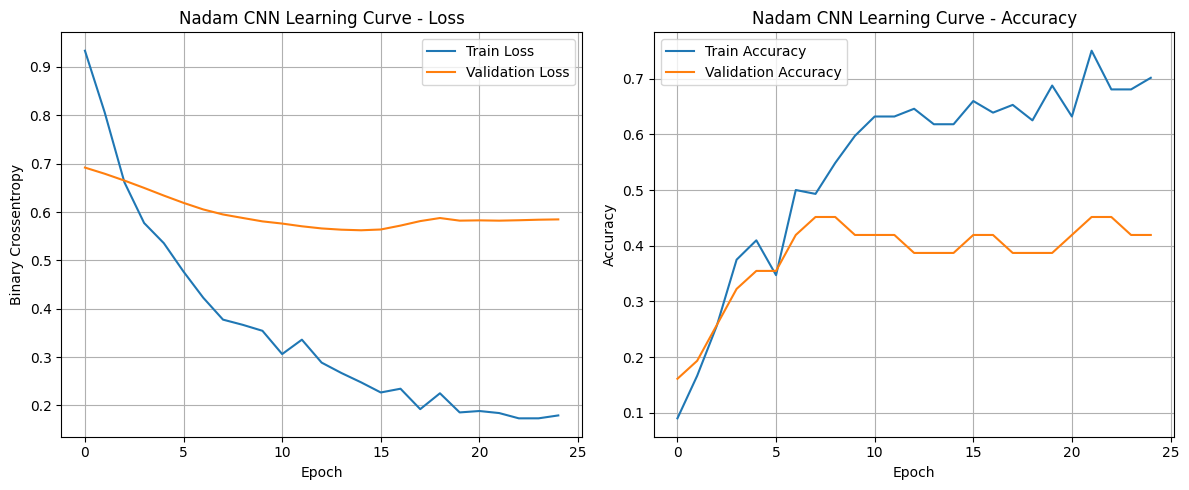

In [46]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_nadam.history['loss'], label='Train Loss')
plt.plot(history_nadam.history['val_loss'], label='Validation Loss')
plt.title('Nadam CNN Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_nadam.history['accuracy'], label='Train Accuracy')
plt.plot(history_nadam.history['val_accuracy'], label='Validation Accuracy')
plt.title('Nadam CNN Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import itertools
import numpy as np


In [48]:
def build_cnn_model(n_features, n_labels, conv_filters=64, kernel_size=3, dense_units=128, dropout_conv=0.3, dropout_dense=0.4, optimizer='adam', lr=0.001):
    model = Sequential()
    model.add(Input(shape=(n_features,1)))

    # Convolutional layer
    model.add(Conv1D(conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_conv))

    model.add(Flatten())

    # Dense layer
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_dense))

    # Output layer
    model.add(Dense(n_labels, activation='sigmoid'))

    # Optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=lr)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=lr)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [49]:
param_grid = {
    'conv_filters': [32, 64],
    'kernel_size': [3, 5],
    'dense_units': [64, 128],
    'dropout_conv': [0.2, 0.3],
    'dropout_dense': [0.3, 0.4],
    'optimizer': ['adam', 'nadam'],
    'lr': [0.001, 0.0005]
}


In [50]:
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Total combinations: {len(combinations)}")


Total combinations: 128


In [ ]:
best_f1 = 0
best_params = None
n_features = X_train_cnn.shape[1]
n_labels = y_train.shape[1]

for i, params in enumerate(combinations):
    print(f"\nTraining combination {i+1}/{len(combinations)}: {params}")
    
    model = build_cnn_model(
        n_features=n_features,
        n_labels=n_labels,
        conv_filters=params['conv_filters'],
        kernel_size=params['kernel_size'],
        dense_units=params['dense_units'],
        dropout_conv=params['dropout_conv'],
        dropout_dense=params['dropout_dense'],
        optimizer=params['optimizer'],
        lr=params['lr']
    )
    
    history = model.fit(
        X_train_cnn, y_train.values,
        validation_data=(X_val_cnn, y_val.values),
        epochs=20,
        batch_size=32,
        verbose=0
    )
    
    y_pred_prob = model.predict(X_val_cnn)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    f1 = f1_score(y_val.values, y_pred, average='micro')
    
    print(f"Micro F1-score: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_params = params



Training combination 1/128: {'conv_filters': 32, 'kernel_size': 3, 'dense_units': 64, 'dropout_conv': 0.2, 'dropout_dense': 0.3, 'optimizer': 'adam', 'lr': 0.001}
1/1 [==============================] - 0s 50ms/step
Micro F1-score: 0.8742

Training combination 2/128: {'conv_filters': 32, 'kernel_size': 3, 'dense_units': 64, 'dropout_conv': 0.2, 'dropout_dense': 0.3, 'optimizer': 'adam', 'lr': 0.0005}
1/1 [==============================] - 0s 63ms/step
Micro F1-score: 0.8345

Training combination 3/128: {'conv_filters': 32, 'kernel_size': 3, 'dense_units': 64, 'dropout_conv': 0.2, 'dropout_dense': 0.3, 'optimizer': 'nadam', 'lr': 0.001}
1/1 [==============================] - 0s 57ms/step
Micro F1-score: 0.8591

Training combination 4/128: {'conv_filters': 32, 'kernel_size': 3, 'dense_units': 64, 'dropout_conv': 0.2, 'dropout_dense': 0.3, 'optimizer': 'nadam', 'lr': 0.0005}
1/1 [==============================] - 0s 62ms/step
Micro F1-score: 0.8079

Training combination 5/128: {'conv_filt

In [ ]:
print("\nBest hyperparameters found:")
print(best_params)
print(f"Best Micro F1-score: {best_f1:.4f}")


In [ ]:
import numpy as np
import pandas as pd

# Combine features
X_combined = np.vstack([X_train_cnn, X_val_cnn])

# Combine labels
y_combined = np.vstack([y_train.values, y_val.values])

print("Combined features shape:", X_combined.shape)
print("Combined labels shape:", y_combined.shape)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

n_features = X_combined.shape[1]
n_labels = y_combined.shape[1]

# Best hyperparameters from grid search
best_params = {
    'conv_filters': 64,
    'kernel_size': 3,
    'dense_units': 128,
    'dropout_conv': 0.2,
    'dropout_dense': 0.4,
    'optimizer': 'adam',
    'lr': 0.001
}

model_final = Sequential([
    Input(shape=(n_features, 1)),

    # Conv1D layer
    Conv1D(best_params['conv_filters'], kernel_size=best_params['kernel_size'], activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(best_params['dropout_conv']),

    Flatten(),

    # Dense layer
    Dense(best_params['dense_units'], activation='relu'),
    Dropout(best_params['dropout_dense']),

    # Output layer for multi-label classification
    Dense(n_labels, activation='sigmoid')
])

# Optimizer
optimizer = Adam(learning_rate=best_params['lr'])
model_final.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_final.summary()


Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_130 (Conv1D)         (None, 30, 64)            256       
                                                                 
 batch_normalization_133 (Ba  (None, 30, 64)           256       
 tchNormalization)                                               
                                                                 
 dropout_261 (Dropout)       (None, 30, 64)            0         
                                                                 
 flatten_130 (Flatten)       (None, 1920)              0         
                                                                 
 dense_261 (Dense)           (None, 128)               245888    
                                                                 
 dropout_262 (Dropout)       (None, 128)               0         
                                                    

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [33]:
history_final = model_final.fit(
    X_combined, y_combined,
    validation_split=0.1,  # Use 10% of combined data for validation during training
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
5/5 [==============================] - 1s 42ms/step - loss: 0.8837 - accuracy: 0.2739 - val_loss: 0.6210 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 0.4160 - accuracy: 0.4968 - val_loss: 0.5780 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 0s 15ms/step - loss: 0.3136 - accuracy: 0.5350 - val_loss: 0.5489 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2380 - accuracy: 0.6561 - val_loss: 0.5288 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 5/50
5/5 [==============================] - 0s 14ms/step - loss: 0.2099 - accuracy: 0.6752 - val_loss: 0.5149 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.1657 - accuracy: 0.6752 - val_loss: 0.5057 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 0.1270 - accuracy

In [34]:
# Reshape X_test
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predict
y_pred_prob = model_final.predict(X_test_cnn)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Final model predictions shape:", y_pred.shape)


1/1 [==============================] - 0s 53ms/step
Final model predictions shape: (32, 6)


In [35]:
label_cols = [
    'Academic workshops',
    'Career development sessions',
    'Cultural programs',
    'Social gatherings',
    'Study groups',
    'Tech events'
]


In [36]:
metrics = []

for i, label in enumerate(label_cols):
    acc = accuracy_score(y_test.values[:, i], y_pred[:, i])
    prec = precision_score(y_test.values[:, i], y_pred[:, i], zero_division=0)
    rec = recall_score(y_test.values[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(y_test.values[:, i], y_pred[:, i], zero_division=0)
    
    metrics.append([label, acc, prec, rec, f1])

metrics_df = pd.DataFrame(metrics, columns=['Label', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
print("Per-label metrics:\n", metrics_df)


Per-label metrics:
                          Label  Accuracy  Precision    Recall  F1-Score
0           Academic workshops   0.96875   0.923077  1.000000  0.960000
1  Career development sessions   0.96875   0.916667  1.000000  0.956522
2            Cultural programs   0.81250   0.625000  0.625000  0.625000
3            Social gatherings   0.93750   0.857143  0.857143  0.857143
4                 Study groups   0.75000   0.636364  0.636364  0.636364
5                  Tech events   0.84375   0.833333  0.769231  0.800000


In [37]:
# Micro-average metrics
micro_precision = precision_score(y_test.values, y_pred, average='micro', zero_division=0)
micro_recall    = recall_score(y_test.values, y_pred, average='micro', zero_division=0)
micro_f1        = f1_score(y_test.values, y_pred, average='micro', zero_division=0)

# Hamming Loss
hl = hamming_loss(y_test.values, y_pred)

print("\nOverall multi-label metrics:")
print(f"Micro Precision: {micro_precision:.3f}")
print(f"Micro Recall:    {micro_recall:.3f}")
print(f"Micro F1-Score:  {micro_f1:.3f}")
print(f"Hamming Loss:    {hl:.3f}")



Overall multi-label metrics:
Micro Precision: 0.810
Micro Recall:    0.823
Micro F1-Score:  0.816
Hamming Loss:    0.120


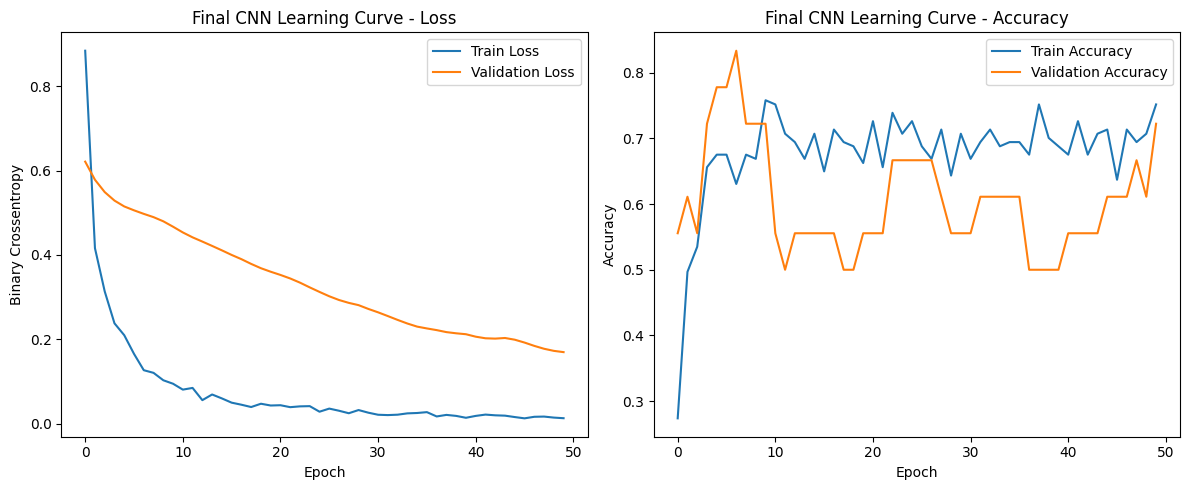

In [39]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Final CNN Learning Curve - Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final CNN Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
